# Load Dependencies

In [2]:
! export GLBACKEND="pytorch"
import numpy as np
import pandas as pd
from pandas import DataFrame
import glob
import torch 
from torch.utils.data import Dataset
import torch.optim as optim
from script_baseline.SEMG import Get_SEMG
from script_baseline.GCN import GCN2
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# Load Data

In [3]:
data_file = '../Data/data2/data2.csv'
mol_dir = '../Data/data2/data2_sdf_files/'

In [4]:
tmp_df = pd.read_csv(data_file)
cat_smiles = tmp_df['Catalyst'].to_list()
imine_smiles = tmp_df['Imine'].to_list()
thiol_smiles = tmp_df['Thiol'].to_list()
labels_ori = tmp_df['Output'].to_list()

cat_smi_set = list(set(cat_smiles))
imine_smi_set = list(set(imine_smiles))
thiol_smi_set = list(set(thiol_smiles))
labels_ori=np.array(labels_ori)

In [5]:
cat_files = glob.glob(mol_dir+'cat_*.sdf')
imine_files = glob.glob(mol_dir+'imine_*.sdf')
thiol_files = glob.glob(mol_dir+'thiol_*.sdf')

In [6]:
with open(mol_dir+'smiles_file_dict.csv','r') as fr:
    lines = fr.readlines()

smiles_name_dict = {tmp_line.strip().split(',')[0]:tmp_line.strip().split(',')[1] for tmp_line in lines}

# Generate Baseline MG

In [7]:
cat_file_graph_dict=Get_SEMG(cat_files)

cat_34
cat_35
cat_25
cat_21
cat_27
cat_12
cat_14
cat_0
cat_24
cat_16
cat_38
cat_20
cat_9
cat_11
cat_28
cat_22
cat_18
cat_30
cat_5
cat_33
cat_15
cat_31
cat_26
cat_8
cat_19
cat_37
cat_1
cat_39
cat_7
cat_36
cat_29
cat_2
cat_13
cat_23
cat_6
cat_32
cat_41
cat_10
cat_17
cat_4
cat_42
cat_3
cat_40


In [8]:
thiol_file_graph_dict=Get_SEMG(thiol_files)

thiol_4
thiol_1
thiol_2
thiol_0
thiol_3


In [9]:
imine_file_graph_dict=Get_SEMG(imine_files)

imine_1
imine_4
imine_3
imine_2
imine_0


# Load Graph Dataset

In [10]:
class Graph_DataSet(Dataset):

    def __init__(self, root,csv_dir='/data2.csv',sdf_dir='/data2_sdf_files/', train=True, transform = None, target_transform=None):
        super(Graph_DataSet, self).__init__()
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        if self.train :
            file_annotation = root +csv_dir
            sdf_folder = root + sdf_dir
        else:
            file_annotation = root +csv_dir
            sdf_folder = root + sdf_dir
        df = pd.read_csv(file_annotation)

        target = np.array(df['Output'].to_list())
        self.target_min = target.min()
        self.target_range = target.max() - target.min()       
        target_std = (target - target.min())/(target.max()-target.min())
        
        cat_smi = df['Catalyst'].to_list()
        imine_smi = df['Imine'].to_list()
        thiol_smi = df['Thiol'].to_list()
         
        cat_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in cat_smi]
        imine_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in imine_smi]
        thiol_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in thiol_smi]
        
        self.cat_file_names = cat_file_names
        self.imine_file_names = imine_file_names
        self.thiol_file_names = thiol_file_names
        
        self.target_std = target_std
        self.sdf_folder = sdf_folder
            
    def __getitem__(self, index):
        cat_name = self.cat_file_names[index]
        imine_name = self.imine_file_names[index]
        thiol_name = self.thiol_file_names[index]
        label = self.target_std[index]

        graph_1 = cat_file_graph_dict[cat_name]
        graph_2 = imine_file_graph_dict[imine_name]
        graph_3 = thiol_file_graph_dict[thiol_name]
        
        return [graph_1,graph_1.ndata['feat'],graph_2,graph_2.ndata['feat'],graph_3,graph_3.ndata['feat']], label

    def __len__(self):
        return len(self.target_std)

# Tain Model

In [11]:
loss = 'mse'
batch_size = 128
shuffle = np.array(list(range(1075)))
np.random.shuffle(shuffle)
train_index = shuffle[:600]
val_index = shuffle[600:]
dataset = Graph_DataSet('../Data/data2',csv_dir='/data2.csv',sdf_dir='/xtb_sdf/')
train_data=[]
for i in train_index:
    tem_data=dataset[i]
    train_data.append(tem_data)
    
val_data=[]
for i in val_index:
    tem_data=dataset[i]
    val_data.append(tem_data)     

In [12]:
model_opt = GCN2(543,256,1,multi_graph_opt='sum',output_opt='mean',layer=3)
optimizer = optim.Adam(model_opt.parameters())
loss_func = torch.nn.L1Loss()

checkpoint=ModelCheckpoint("../Dataset/run_data/model_cusgraph.hdf5",
                               verbose=0,monitor='loss',
                               save_best_only=True,mode='min')

for epoch in range(50):
    get_output=[] 
    all_loss = []
    model_opt.train()
    for i, data in enumerate(train_data):
        inputs, labels = data
        outputs = model_opt(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],)
        get_output.append(outputs)

        labels = torch.tensor(labels) 
        
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        all_loss.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
    print('Train MSE',np.mean(all_loss))
    model_opt.eval()
    test_get_output=[]
    test_all_labels = []
    all_loss = []
    for data in val_data:
        inputs, labels = data
        outputs = model_opt(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],)
        test_get_output.append(outputs)
        labels = torch.tensor(labels) 
        test_all_labels.append(labels)
        loss = loss_func(outputs, labels)
        all_loss.append(loss.detach().numpy())
    print('Test MSE',np.mean(all_loss))   

Train MSE 0.26410619602672275
Test MSE 0.10527158456829319
Train MSE 0.09800075154436555
Test MSE 0.07895703356522064
Train MSE 0.08394890447804776
Test MSE 0.0706548653832807
Train MSE 0.08145581589224224
Test MSE 0.06745594820631345
Train MSE 0.07768024366391554
Test MSE 0.07173661071022928
Train MSE 0.07417004735723234
Test MSE 0.06434695983902437
Train MSE 0.07058707273964439
Test MSE 0.06605537057071195
Train MSE 0.07444442705439017
Test MSE 0.07073626095798356
Train MSE 0.06960963024188203
Test MSE 0.06608458179083122
Train MSE 0.07296127932431215
Test MSE 0.07070094236131995
Train MSE 0.06732114343227577
Test MSE 0.08941475754183364
Train MSE 0.07101242485330109
Test MSE 0.08065748036531277
Train MSE 0.06839362753661196
Test MSE 0.07820173420908894
Train MSE 0.06570176332553422
Test MSE 0.06498819889909933
Train MSE 0.06547407002969549
Test MSE 0.08339712115488646
Train MSE 0.06643154255860548
Test MSE 0.07191789136421722
Train MSE 0.0625211868649346
Test MSE 0.05923302019515156

In [13]:
test_all_labels_=[]
for i in test_all_labels:
    test_all_labels_.append(i.tolist())
    
test_get_output_=[]
for i in test_get_output:
    test_get_output_.append(i.tolist())
y_val=np.array(test_all_labels_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()
y_pred=np.array(test_get_output_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()

# Results

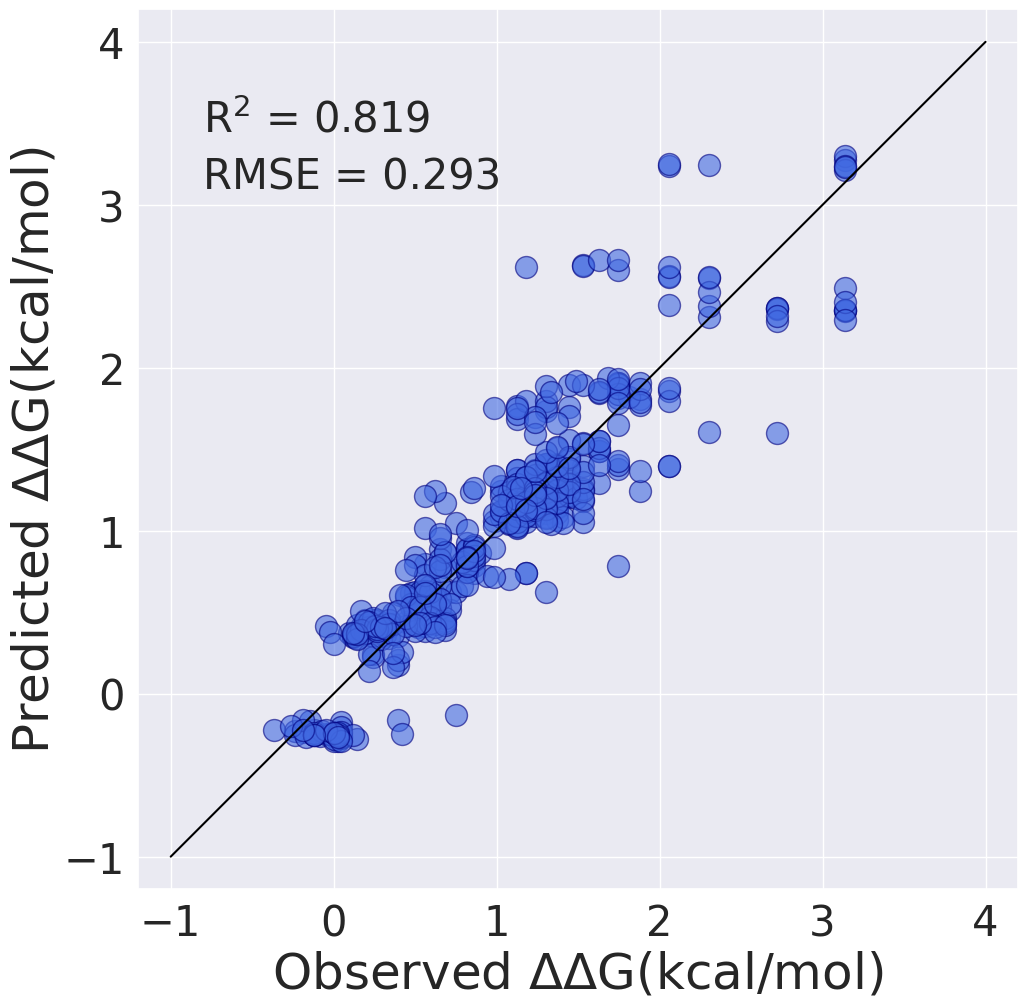

In [14]:
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',   
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-1,4],[-1,4],c='black')
plt.xlim(-1.2,4.2)
plt.ylim(-1.2,4.2)
x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed $\Delta$$\Delta$G(kcal/mol)",fontsize=36)
plt.ylabel("Predicted $\Delta$$\Delta$G(kcal/mol)",fontsize=36)
plt.tick_params(labelsize=30)
plt.text(-0.8,3.1,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(-0.8,3.45,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

In [15]:
np.save( '../result/data2_SEMG_GCN_y_val.npy',y_val)
np.save( '../result/data2_SEMG_GCN_y_pred.npy',y_pred)